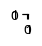

In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import itertools
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [12]:
cedar = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
cedar['ratio_new'] = cedar.apply(lambda x: (x['EL_rank_mut']+0.01) / (x['EL_rank_wt_aligned']+0.01),axis=1)

In [13]:
from sklearn.metrics import roc_auc_score

roc_auc_score(cedar['agg_label'], 1-cedar['ratio_new']), roc_auc_score(cedar['agg_label'], 1-cedar['ratio_new'], max_fpr=0.1)

(0.5357972291975388, 0.5213618311928871)

In [14]:
prime = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')

In [15]:
cedar['wild_type'].to_csv('/Users/riwa/Documents/code/uniprot_query/cedar_wt.txt', index=False,header=False)
prime['wild_type'].to_csv('/Users/riwa/Documents/code/uniprot_query/prime_wt.txt', index=False,header=False)


In [16]:
pd.read_csv('../data/human_proteome/predictions_human_100k.csv')

,Peptide,icore_mut,icore_wt_aligned,HLA,mean_pred,id
0,SLPSFGEIKL,SLPSFGEIKL,SLPSFSEIKL,HLA-A0201,0.049605,seq_24016
1,SQFLSGPQKSM,SQFLSGPQKSM,SQFLSGPQKSS,HLA-B4001,0.050406,seq_71636
2,GVPRVHQSSTF,GVPRVHQSSTF,GVPRLHQSSTF,HLA-A2402,0.051775,seq_46007
3,KLRKAPQDSSL,KLRKAPQDSSL,LLRKAPQDSSL,HLA-B0702,0.052682,seq_57215
4,KIFSGPSSEQ,KIFSGPSSEQ,KIFSGPSSEQ,HLA-A0301,0.052701,seq_85707
...,...,...,...,...,...,...
108367,RPFYDHVIY,RPFYDHVIY,RPFYRHVIY,HLA-B3501,0.527700,seq_95993
108368,DVFSVIYVR,DVFSVIYVR,DVFSVIGVR,HLA-A6801,0.546326,seq_90373
108369,FIDYHIAEL,FIDYHIAEL,FIDKHIAEL,HLA-A0201,0.552299,seq_6306
108370,YTDTYTWAY,YTDTYTWAY,YTDTYTEAY,HLA-A0101,0.553253,seq_76624


In [17]:
from Bio import SeqIO

# Replace 'your_fasta_file.fasta' with the actual filename
fasta_file = '../data/human_proteome/_old/Human.fasta'

# Read the FASTA file
sequences = SeqIO.parse(fasta_file, 'fasta')
results = []
# Iterate through the sequences
for sequence_record in sequences:
    sequence_id = sequence_record.id
    sequence_description = sequence_record.description
    sequence = sequence_record.seq
    results.append([sequence_id, sequence_description, str(sequence)])
human_df = pd.DataFrame(results, columns = ['ID', 'desc', 'seq'])

In [18]:
from joblib import Parallel, delayed
from functools import partial
def query(f):
    if len(human_df.query('seq.str.contains(@f)'))==0:
        return f
    else:
        return 'found'

In [19]:
notfound_cedar = [x for x in Parallel(n_jobs=8)(delayed(query)(f=f) for f in tqdm(cedar['wild_type'].unique(), desc='wt')) if x !='found']
print(len(notfound_cedar))

wt: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2896/2896 [00:59<00:00, 48.71it/s]


89


In [20]:
notfound_prime = [x for x in Parallel(n_jobs=8)(delayed(query)(f=f) for f in tqdm(prime['wild_type'].unique(), desc='wt')) if x !='found']
print(len(notfound_prime))

wt: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3056/3056 [00:31<00:00, 97.44it/s]


201


In [24]:
with open('../../human_proteome/CEDAR_notfoundWT.fa', 'w') as f:
    for i, seq in enumerate(sorted(notfound_cedar)):
        f.write(f'>seq_{i:03}\n')
        f.write(f'{seq}\n')
with open('../../human_proteome/PRIME_notfoundWT.fa', 'w') as f:
    for i, seq in enumerate(sorted(notfound_prime)):
        f.write(f'>seq_{i:03}\n')
        f.write(f'{seq}\n')
    

In [27]:
cedar['seq_id'] = [f'cedar_seq_{i:04}' for i in range(len(cedar))]
prime['seq_id'] = [f'prime_seq_{i:04}' for i in range(len(prime))]

In [37]:
with open('../../human_proteome/CEDAR_all_WT.fa', 'w') as f:
    for x in cedar.iterrows():
        f.write(f'>{x[1]["seq_id"]}\n')
        f.write(f'{x[1]["wild_type"]}\n')
with open('../../human_proteome/PRIME_all_WT.fa', 'w') as f:
    for x in prime.iterrows():
        f.write(f'>{x[1]["seq_id"]}\n')
        f.write(f'{x[1]["wild_type"]}\n')


In [41]:
human_df.query('seq.str.contains(@cedar["wild_type"].iloc[5])')

,ID,desc,seq
7860,sp|Q12950|FOXD4_HUMAN,sp|Q12950|FOXD4_HUMAN Forkhead box protein D4 ...,MNLPRAERLRSTPQRSLRDSDGEDGKIDVLGEEEDEDEEEAASQQF...
11013,sp|Q6VB84|FX4L3_HUMAN,sp|Q6VB84|FX4L3_HUMAN Forkhead box protein D4-...,MNLPRAERLRSTPQRSLRDSDGEDGKIDVLGEEEDEDEVEDEEEAA...
18471,sp|Q9NU39|FX4L1_HUMAN,sp|Q9NU39|FX4L1_HUMAN Forkhead box protein D4-...,MNLPRAERPRSTPQRSLRDSDGEDGKIDVLGEEEDEDEVEDEEEEA...


In [ ]:
from joblib import Parallel, delayed
from functools import partial
def map_wt(wt, human_df):
    query=human_df.query('seq.str.contains(@wt)'))
    

In [22]:
cedar.query('wild_type=="ALQNYDNKLV"')

,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,...,VHSE1,VHSE3,VHSE7,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,ratio_rank,foreignness_score,ratio_new
96,96,96,HLA-A0201,0,2,ALQNFDNKLV,ALQNYDNKLV,ALQNFDNKL,ALQNFDNKL,10,...,-0.096667,0.006667,0.234444,-0.360000,>seq_97,ALQNYDNKL,0.4357,0.054458,0.000000e+00,0.856854
97,97,97,HLA-A0201,0,2,ALQNYYNKLV,ALQNYDNKLV,ALQNYYNKL,ALQNYYNKL,10,...,-0.002222,0.205556,0.165556,-0.515556,>seq_98,ALQNYDNKL,0.4357,0.055738,3.475804e-09,1.112183


# ESM

## load data and do pca

In [57]:
# Forgot to do NEPDB, so doing it here.

nepdb = pd.read_csv('../data/aligned_icore/230418_nepdb_aligned.csv')
with open('../../human_proteome/NEPDB_all_WT.fa', 'w') as f:
    nepdb['seq_id'] = [f'nepdb_seq_{i:04}' for i in range(len(nepdb))]
    for x in nepdb.iterrows():
        f.write(f'>{x[1]["seq_id"]}\n')
        f.write(f'{x[1]["wild_type"]}\n')

In [58]:
from sklearn.decomposition import PCA, KernelPCA
cedar_esm = pd.read_csv('../data/esm/cedar_seq_mean_repr.csv')
prime_esm = pd.read_csv('../data/esm/prime_seq_mean_repr.csv')
nepdb_esm = pd.read_csv('../data/esm/nepdb_seq_mean_repr.csv')

In [59]:
cedar_merged = pd.merge(cedar, cedar_esm, left_on=['seq_id'], right_on=['seq_id'])
prime_merged = pd.merge(prime, prime_esm, left_on=['seq_id'], right_on=['seq_id'])
nepdb_merged = pd.merge(nepdb, nepdb_esm, left_on=['seq_id'], right_on=['seq_id'])

In [60]:
pca25 = PCA(n_components=25, random_state=13)

pcas_values_cedar = pca25.fit_transform(cedar_esm.drop(columns=['seq_id']).values)
pcas_values_prime = pca25.transform(prime_esm.drop(columns=['seq_id']).values)
pcas_values_nepdb = pca25.transform(nepdb_esm.drop(columns=['seq_id']).values)

for i in range(1,26):
    cedar_merged[f'ESM_PCA_{i:02}'] = pcas_values_cedar[:, i-1]
    prime_merged[f'ESM_PCA_{i:02}'] = pcas_values_prime[:, i-1]
    nepdb_merged[f'ESM_PCA_{i:02}'] = pcas_values_nepdb[:, i-1]
    

In [61]:
cedar_merged.to_csv('../data/esm/230905_cedar_esm_pca.csv', index=False)
prime_merged.to_csv('../data/esm/230905_prime_esm_pca.csv', index=False)
nepdb_merged.to_csv('../data/esm/230905_nepdb_esm_pca.csv', index=False)

## Run some model, train on cedar, eval on prime, etc.

In [66]:
pd.set_option('display.max_columns', 9999)
cedar_merged.head()

,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,trueHLA_EL_rank,icore_mut_start,len_icore_mut,icore_wt_aligned,icore_dissimilarity_score,icore_len_mut,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,ratio_rank,foreignness_score,ratio_new,dim_0001,dim_0002,dim_0003,dim_0004,dim_0005,dim_0006,dim_0007,dim_0008,dim_0009,dim_0010,dim_0011,dim_0012,dim_0013,dim_0014,dim_0015,dim_0016,dim_0017,dim_0018,dim_0019,dim_0020,dim_0021,dim_0022,dim_0023,dim_0024,dim_0025,dim_0026,dim_0027,dim_0028,dim_0029,dim_0030,dim_0031,dim_0032,dim_0033,dim_0034,dim_0035,dim_0036,dim_0037,dim_0038,dim_0039,dim_0040,dim_0041,dim_0042,dim_0043,dim_0044,dim_0045,dim_0046,dim_0047,dim_0048,dim_0049,dim_0050,dim_0051,dim_0052,dim_0053,dim_0054,dim_0055,dim_0056,dim_0057,dim_0058,dim_0059,dim_0060,dim_0061,dim_0062,dim_0063,dim_0064,dim_0065,dim_0066,dim_0067,dim_0068,dim_0069,dim_0070,dim_0071,dim_0072,dim_0073,dim_0074,dim_0075,dim_0076,dim_0077,dim_0078,dim_0079,dim_0080,dim_0081,dim_0082,dim_0083,dim_0084,dim_0085,dim_0086,dim_0087,dim_0088,dim_0089,dim_0090,dim_0091,dim_0092,dim_0093,dim_0094,dim_0095,dim_0096,dim_0097,dim_0098,dim_0099,dim_0100,dim_0101,dim_0102,dim_0103,dim_0104,dim_0105,dim_0106,dim_0107,dim_0108,dim_0109,dim_0110,dim_0111,dim_0112,dim_0113,dim_0114,dim_0115,dim_0116,dim_0117,dim_0118,dim_0119,dim_0120,dim_0121,dim_0122,dim_0123,dim_0124,dim_0125,dim_0126,dim_0127,dim_0128,dim_0129,dim_0130,dim_0131,dim_0132,dim_0133,dim_0134,dim_0135,dim_0136,dim_0137,dim_0138,dim_0139,dim_0140,dim_0141,dim_0142,dim_0143,dim_0144,dim_0145,dim_0146,dim_0147,dim_0148,dim_0149,dim_0150,dim_0151,dim_0152,dim_0153,dim_0154,dim_0155,dim_0156,dim_0157,dim_0158,dim_0159,dim_0160,dim_0161,dim_0162,dim_0163,dim_0164,dim_0165,dim_0166,dim_0167,dim_0168,dim_0169,dim_0170,dim_0171,dim_0172,dim_0173,dim_0174,dim_0175,dim_0176,dim_0177,dim_0178,dim_0179,dim_0180,dim_0181,dim_0182,dim_0183,dim_0184,dim_0185,dim_0186,dim_0187,dim_0188,dim_0189,dim_0190,dim_0191,dim_0192,dim_0193,dim_0194,dim_0195,dim_0196,dim_0197,dim_0198,dim_0199,dim_0200,dim_0201,dim_0202,dim_0203,dim_0204,dim_0205,dim_0206,dim_0207,dim_0208,dim_0209,dim_0210,dim_0211,dim_0212,dim_0213,dim_0214,dim_0215,dim_0216,dim_0217,dim_0218,dim_0219,dim_0220,dim_0221,dim_0222,dim_0223,dim_0224,dim_0225,dim_0226,dim_0227,dim_0228,dim_0229,dim_0230,dim_0231,dim_0232,dim_0233,dim_0234,dim_0235,dim_0236,dim_0237,dim_0238,dim_0239,dim_0240,dim_0241,dim_0242,dim_0243,dim_0244,dim_0245,dim_0246,dim_0247,dim_0248,dim_0249,dim_0250,dim_0251,dim_0252,dim_0253,dim_0254,dim_0255,dim_0256,dim_0257,dim_0258,dim_0259,dim_0260,dim_0261,dim_0262,dim_0263,dim_0264,dim_0265,dim_0266,dim_0267,dim_0268,dim_0269,dim_0270,dim_0271,dim_0272,dim_0273,dim_0274,dim_0275,dim_0276,dim_0277,dim_0278,dim_0279,dim_0280,dim_0281,dim_0282,dim_0283,dim_0284,dim_0285,dim_0286,dim_0287,dim_0288,dim_0289,dim_0290,dim_0291,dim_0292,dim_0293,dim_0294,dim_0295,dim_0296,dim_0297,dim_0298,dim_0299,dim_0300,dim_0301,dim_0302,dim_0303,dim_0304,dim_0305,dim_0306,dim_0307,dim_0308,dim_0309,dim_0310,dim_0311,dim_0312,dim_0313,dim_0314,dim_0315,dim_0316,dim_0317,dim_0318,dim_0319,dim_0320,dim_0321,dim_0322,dim_0323,dim_0324,dim_0325,dim_0326,dim_0327,dim_0328,dim_0329,dim_0330,dim_0331,dim_0332,dim_0333,dim_0334,dim_0335,dim_0336,dim_0337,dim_0338,dim_0339,dim_0340,dim_0341,dim_0342,dim_0343,dim_0344,dim_0345,dim_0346,dim_0347,dim_0348,dim_0349,dim_0350,dim_0351,dim_0352,dim_0353,dim_0354,dim_0355,dim_0356,dim_0357,dim_0358,dim_0359,dim_0360,dim_0361,dim_0362,dim_0363,dim_0364,dim_0365,dim_0366,dim_0367,dim_0368,dim_0369,dim_0370,dim_0371,dim_0372,dim_0373,dim_0374,dim_0375,dim_0376,dim_0377,dim_0378,dim_0379,dim_0380,dim_0381,dim_0382,dim_0383,dim_0384,dim_0385,dim_0386,dim_0387,dim_0388,dim_0389,dim_0390,dim_0391,d

In [68]:
%mkdir ../output/230905_ESM_embeddings/

In [87]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.metrics import get_metrics, get_nested_feature_importance
from src.bootstrap import bootstrap_eval
from tqdm.auto import tqdm

cedar_merged = pd.read_csv('../data/esm/230905_cedar_esm_pca.csv')
prime_merged = pd.read_csv('../data/esm/230905_prime_esm_pca.csv')
nepdb_merged = pd.read_csv('../data/esm/230905_nepdb_esm_pca.csv')

# Here, I can do remove pep and don't add rank
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,
                   'threshold':0.2,
                   'invert':False,
                   'add_rank': False,
                   'seq_col': 'icore_mut',
                   'rank_col': 'EL_rank_mut',
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': True,
                   'standardize': True}

esm_cols = [x for x in cedar_merged.columns if x.startswith('dim_')]
pca_cols = [f'ESM_PCA_{i:02}' for i in range(1,26)]
outdir = '../output/230905_ESM_embeddings/'

for add_rank in [True, False]:
    for remove_pep in [True, False]:
        for mut_cols, name in zip([pca_cols, esm_cols], ['ESM_PCA', 'ESM_mean']):
            encoding_kwargs['mut_col'] = mut_cols
            encoding_kwargs['add_rank'] = add_rank
            encoding_kwargs['remove_pep'] = remove_pep
            filename = f'removePep{remove_pep}_addRank{add_rank}_{name}'
            
            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=9, ccp_alpha=9.945e-6)
            trained_models, _, _ = nested_kcv_train_sklearn(cedar_merged, model, None, encoding_kwargs, n_jobs=8)
            fi = get_nested_feature_importance(trained_models)
            fn = []
            if not remove_pep:
                fn.extend(AA_KEYS)
            if add_rank:
                fn.extend(['%Rank'])
            fn.extend(mut_cols)
            # Saving Feature importances as dataframe
            df_fi = pd.DataFrame(fi, index=fn).T
            df_fi.to_csv(f'{outdir}featimps_{filename}.csv',index=True)
            for evalset, evalname in zip([cedar_merged, prime_merged, nepdb_merged],
                                         ['CEDAR', 'PRIME', 'NEPDB']):
                # FULLY FILTERED + Mean_pred
                if not evalset.equals(cedar_merged):
                    kcv_eval = False
                    evalset = evalset.query('Peptide not in @train_dataset.Peptide.values').copy()
                else:
                    kcv_eval = True
        
                # print(evalname, len(evalset), evalset.columns)
                _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']),
                                                           trained_models, None,
                                                           cedar_merged,
                                                           encoding_kwargs, concatenated=False,
                                                           only_concat=False, n_jobs=8, kcv_eval=kcv_eval)
                p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
                preds.to_csv(f'{outdir}/{evalname}_preds_{filename}.csv', index=False,
                             columns=['HLA', 'Peptide', 'agg_label', 'icore_mut', 'icore_wt_aligned'] + mut_cols + [p_col])
                bootstrapped_df = bootstrap_eval(preds[p_col], preds['agg_label'], n_rounds=10000, n_jobs=8, reduced=True)
                bootstrapped_df['remove_pep'] = remove_pep
                bootstrapped_df['add_rank'] = add_rank
                
                bootstrapped_df.to_csv(f'{outdir}/bootstrapped_df_{evalname}_{filename}.csv', index=False)
                



Inner Folds:   0%|                                                                                                                   | 0/9 [00:00<?, ?it/s]
                                                                                                                                                           

Inner Folds:   0%|                                                                                                                   | 0/9 [00:00<?, ?it/s]
                                                                                                                                                           

Inner Folds:   0%|                                                                                                                   | 0/9 [00:00<?, ?it/s]
                                                                                                                                                           

Inner Folds:   0%|                                         

Sampling



Bootstrapping rounds: 100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 9968/10000 [00:11<00:00, 962.61it/s]
                                                                                                                                                           

Making results DF and curves


NameError: name 'remove_aa' is not defined

(2480, 26)
(2400, 26)
(2500, 26)
(2422, 26)
(2453, 26)
(2350, 26)
(2392, 26)
(2492, 26)
(2474, 26)
(2353, 26)
(2478, 26)
(2350, 26)
(2450, 26)
(2453, 26)
(2463, 26)
(2422, 26)
(2416, 26)
(2331, 26)
(2392, 26)
(2457, 26)
(2350, 26)
(2439, 26)
(2350, 26)
(2500, 26)
(2416, 26)
(2400, 26)
(2414, 26)
(2392, 26)
(2411, 26)
(2407, 26)
(2417, 26)
(2417, 26)
(2372, 26)
(2431, 26)
(2451, 26)
(2486, 26)
(2353, 26)
(2353, 26)
(2455, 26)
(2449, 26)
(2400, 26)
(2431, 26)
(2486, 26)
(2517, 26)
(2419, 26)
(2494, 26)
(2450, 26)
(2455, 26)
(2419, 26)
(2439, 26)
(2388, 26)
(2449, 26)
(2388, 26)
(2392, 26)
(2480, 26)
(2411, 26)
(2431, 26)
(2394, 26)
(2494, 26)
(2461, 26)
(2353, 26)
(2394, 26)
(2414, 26)
(2410, 26)
(2488, 26)
(2331, 26)
(2436, 26)
(2407, 26)
(2492, 26)
(2413, 26)
(2457, 26)
(2372, 26)
(2417, 26)
(2478, 26)
(2388, 26)
(2394, 26)
(2417, 26)
(2436, 26)
(2488, 26)
(2394, 26)
(2463, 26)
(2410, 26)
(2400, 26)
(2431, 26)
(2461, 26)
(2451, 26)
(2388, 26)
(2474, 26)
(2413, 26)
(2517, 26)
